## Neuron
Create spike raster from inhomogeneous Poisson processes, where the time-dependent rate is modelled as an OU process

In [12]:
using Pkg
Pkg.activate("../")
using CairoMakie
using Random
using Distributions
using StatsBase
using LinearAlgebra
using DSP

  Activating project at `~/git/projects/perspective_heart_and_brain`


# Example EEG data
From https://www.ukbonn.de/epileptologie/arbeitsgruppen/ag-lehnertz-neurophysik/downloads/ 

Reference: Andrzejak RG, Lehnertz K, Rieke C, Mormann F, David P, Elger CE (2001) Indications of nonlinear deterministic and finite dimensional structures in time series of brain electrical activity: Dependence on recording region and brain state,Phys. Rev. E, 64, 061907

Dataset A, sample Z093 as suggested in the reference link

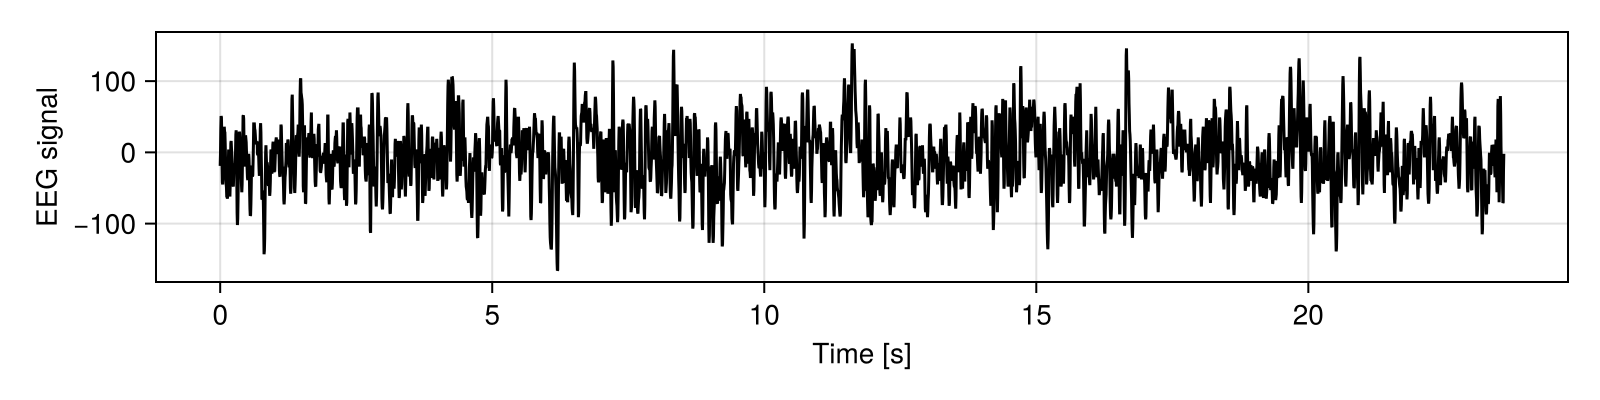

In [38]:
using DelimitedFiles
function eeg_data(path, file)
    eeg_trace = readdlm(joinpath(path, file))[:,1]
    dt = 1/173.61
    eeg_time = 0:dt:(length(eeg_trace)-1)*dt

    return eeg_time, eeg_trace
end

# load data from textfile
eeg_t, eeg_example = eeg_data("../data/Andrzejak_et_al_PhysRevE_2001_setA", "Z093.txt")

fig = Figure(size = (800, 200))
ax = Axis(fig[1, 1]; xlabel = "Time [s]", ylabel = "EEG signal")
lines!(ax, eeg_t, eeg_example, color = :black)
# save as pdf
save("../figures/eeg_example.pdf", fig)
fig

### small analysis of EEG signal to justify spiking generation

In [3]:
# calculate autocorrelation of EEG signal
function autocorrelation(x::Vector{T}, k::Int, mean = nothing) where T
    if isnothing(mean)
        mean = sum(x)/length(x)
    end

    C = 0
    for i in 1:(length(x)-k)
        C += (x[i] - mean)*(x[i+k] - mean)
    end
    return C / (length(x)-k)

end
ks = 0:500
Cs = [autocorrelation(eeg_example, k) for k in ks]
Cs = Cs / Cs[1];

[0.16578569683705643, 0.10591361449950815, 0.946182667969959, 0.013046536578593905]
first timescale: 0.10591361449950815 +/- 0.03307080283440342
second timescale: 0.013046536578593905 +/- 0.0017576564973908633


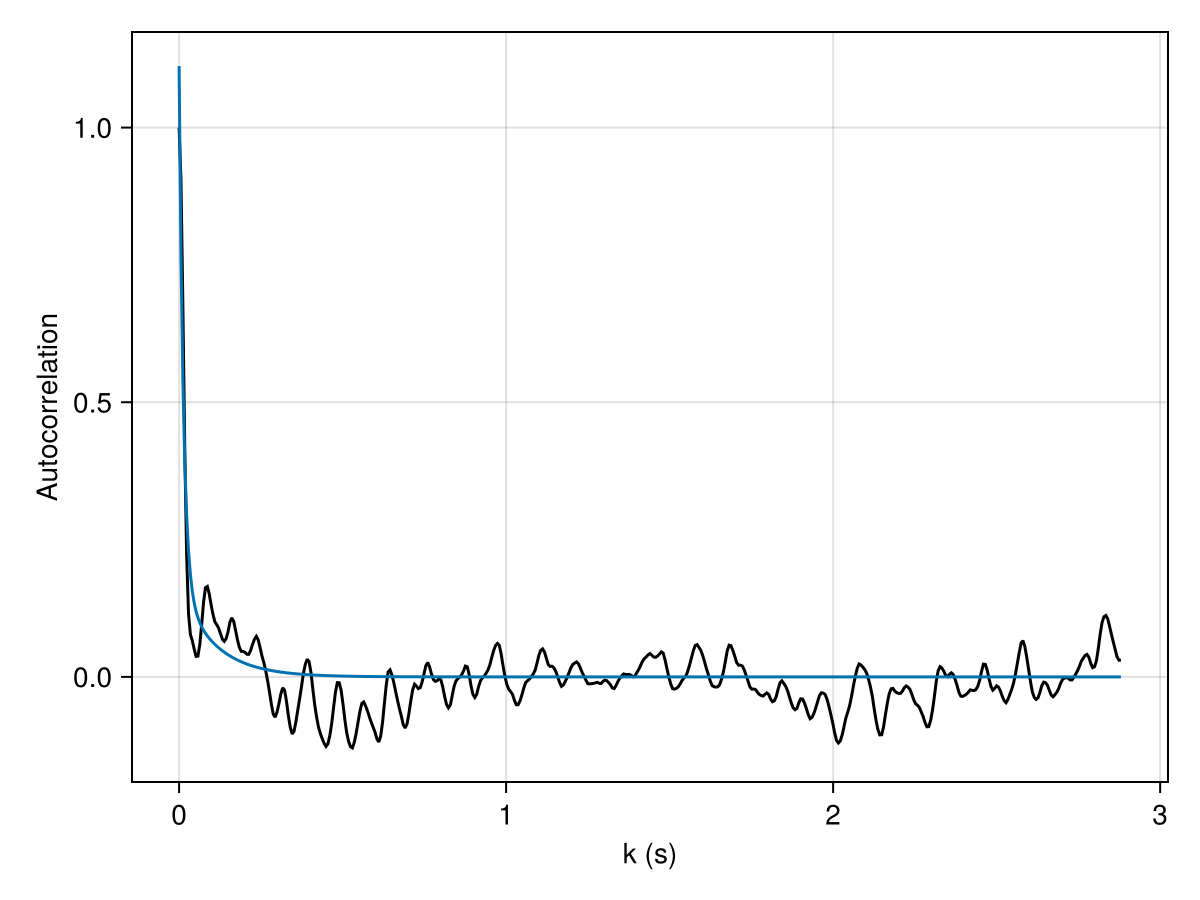

In [16]:
# determine autcorrelation time as decay time of initial autocorrelation
using LsqFit
@. model(x, p) = p[1]*exp(-x/p[2]) + p[3]*exp(-x/p[4])
dt = eeg_t[2] - eeg_t[1]

myfit = curve_fit(model, ks*dt, Cs, [1,0.5, 0.1, 2])
println(myfit.param)
param = myfit.param
error = stderror(myfit)
print("first timescale: ", param[2], " +/- ", error[2], "\n")
print("second timescale: ", param[4], " +/- ", error[4], "\n")

# plot
fig = Figure()
ax = Axis(fig[1, 1]; xlabel = "k (s)", ylabel = "Autocorrelation")
lines!(ax, ks*dt, Cs, color = :black)
lines!(ax, ks*dt, model(ks*dt, param) )
fig

In [25]:
#Average correlation function from all 100 traces from dataset
using ProgressMeter
using Printf 
ks = 0:500
Cs = zeros(length(ks))
@showprogress for i in 1:100
    eeg_t, eeg_example = eeg_data("../data/Andrzejak_et_al_PhysRevE_2001_setA", "Z"*lpad(i, 3, '0')*".txt")
    Cs_tmp = [autocorrelation(eeg_example, k) for k in ks]
    Cs += Cs_tmp ./ Cs_tmp[1]
end
Cs = Cs / 100


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


501-element Vector{Float64}:
 1.0
 0.9243492974050608
 0.7594029279120481
 0.5678716898444497
 0.41366345235474783
 0.3153260405502208
 0.26121758695062935
 0.23130856016584356
 0.20808052563065552
 0.19594720381824107
 ⋮
 0.011162062371706652
 0.014356811854736478
 0.013041043232074374
 0.011344834966130908
 0.011147305022931533
 0.00958974357600009
 0.007182693255244565
 0.00721283287490422
 0.008271987566200137

0.052000000000000005

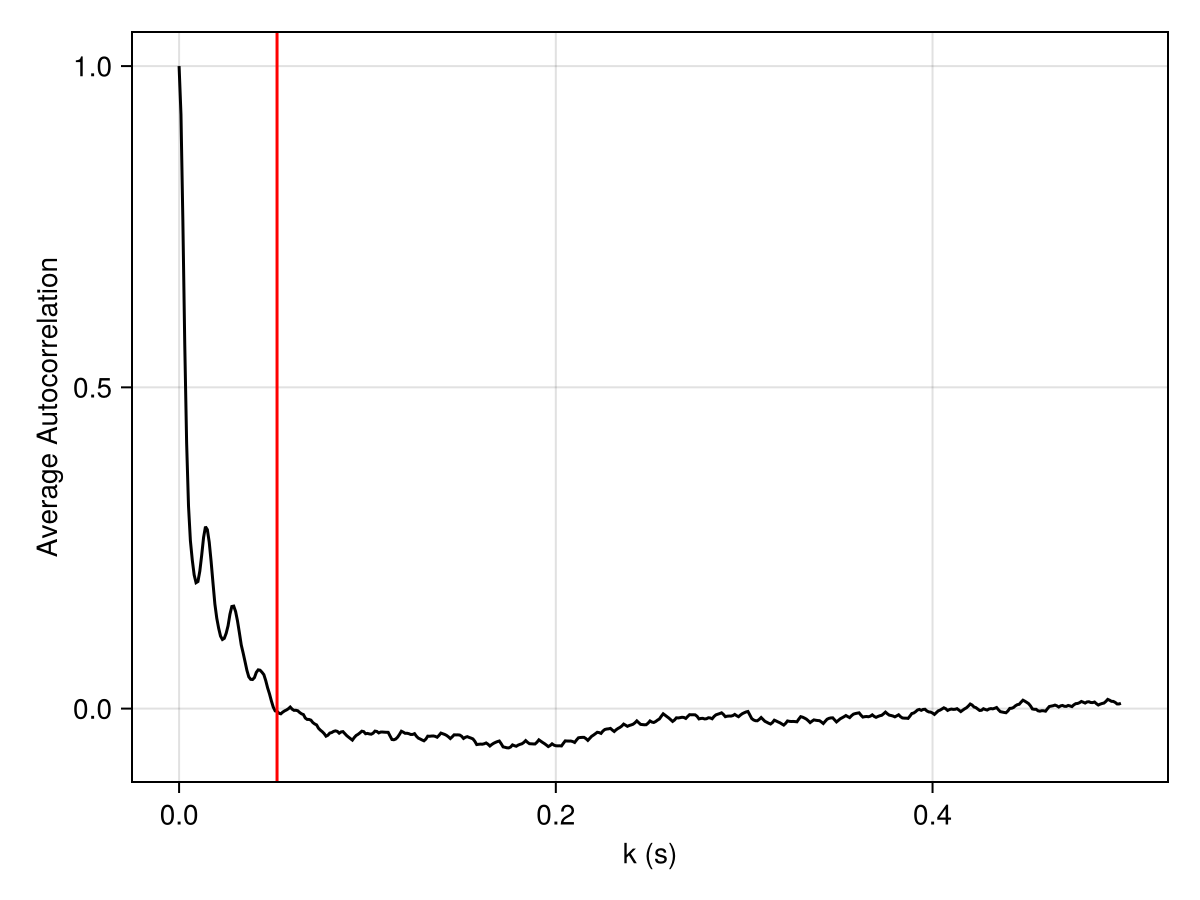

In [37]:
# plot and average autocorrelation and check for zero crossing
tau = findfirst(x -> x < 0, Cs) * dt
print(tau)

fig = Figure()
ax = Axis(fig[1, 1]; xlabel = "k (s)", ylabel = "Average Autocorrelation")
lines!(ax, ks*dt, Cs, color = :black)
# vertical line at tau
vlines!(ax, [tau], color = :red)
fig

# Spike times from inhomog. Poisson with population rate described by OU process with 0.1s autocorrelation time

0.09619538146289373


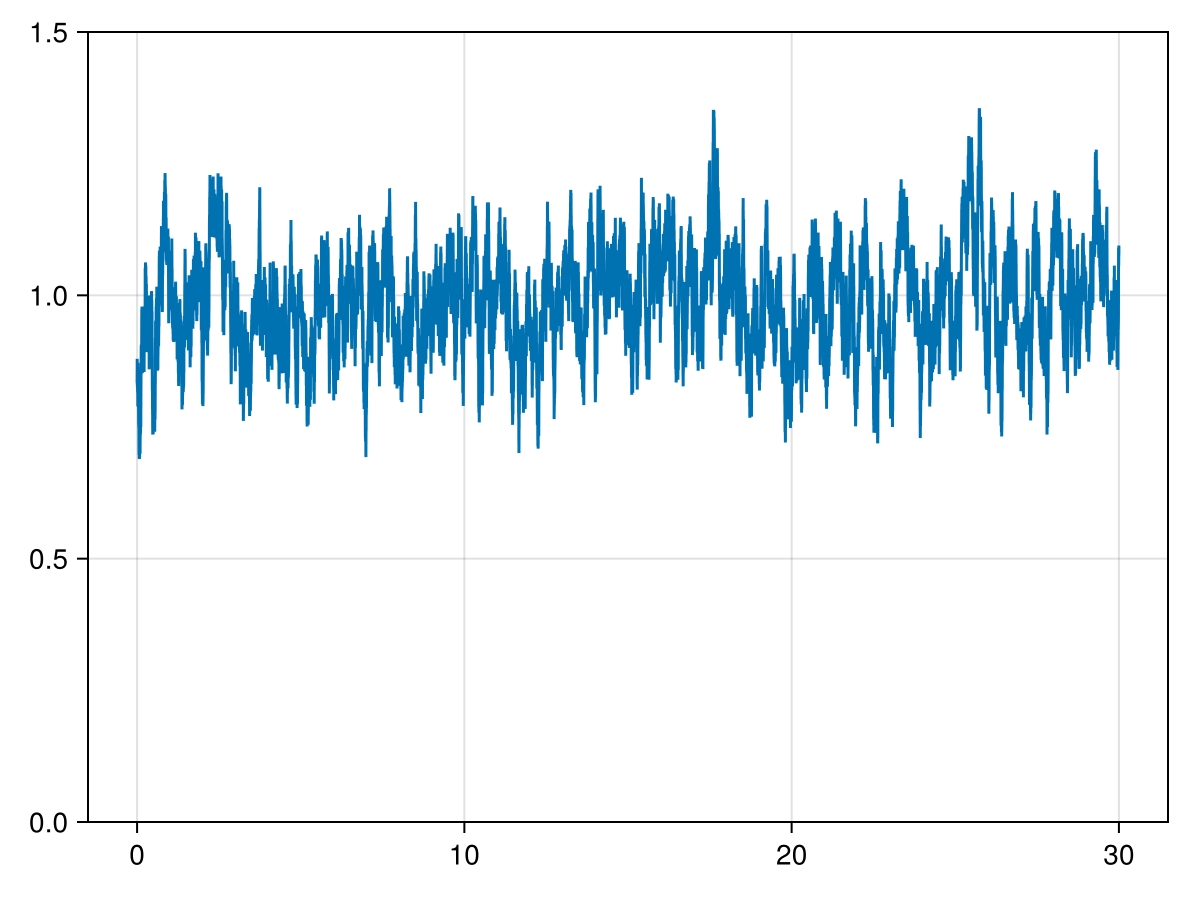

In [11]:
N = 100
# time-dependent rate of population (population AR process with correlation should be the same as OU...)
rate_μ = 1   # Hz
rate_σ = 0.1 # Hz
τ = 0.1   # s
dt = 1e-4 # s
t = 0:dt:30
# ornstein uhlenbeck process for the rate
rate = zeros(length(t))
rate[1] = rate_μ + rate_σ * randn()
for i in 2:length(rate)
    rate[i] = rate[i-1] + (rate_μ - rate[i-1]) * dt / τ + rate_σ * sqrt(2 * dt / τ) * randn()
end
# print std of rate
println(std(rate))
# quick plot to show the outcome
fig = Figure()
ax = Axis(fig[1, 1])
lines!(ax, t, rate)
# y axis range
ylims!(ax, 0, 1.5)
fig

In [13]:
# spike times as independent realizations of inhomogeneous Poisson process 
spikes = [ Float64[] for _ in 1:N]
# here, they all share the same population rate such that we can generate a single process with rate = r*N and assign each spike to a random neurons
rate_all = rate * N
rate_max = maximum(rate_all)
t_ = 0
# advance time with homogeneous poisson process at rate_max (i.e. exp. inter-event times)
dist_dt = Exponential(1/rate_max)
while t_ < t[end]
    #t_ += -log(rand()) / rate_max
    t_ += rand(dist_dt)
    # a spike happens at t_ with probability rate_all[findfirst(x -> x > t_, t)]/rate_max
    if t_ < t[end] && rand() < rate_all[findfirst(x -> x > t_, t)]/rate_max
        # choose random neuron to append this spike time
        push!(spikes[rand(1:N)], t_)
    end
end
spikes

100-element Vector{Vector{Float64}}:
 [1.7153395168277121, 1.7591898791615832, 2.0138560649104353, 2.891500485703304, 3.4171505693677537, 4.009787627715572, 4.1827836130598985, 4.586214870265118, 5.177884319362305, 5.7214849035760205  …  19.995508633553, 20.020884748478373, 21.58588583919567, 23.60757091640947, 25.439772727518037, 25.69739670629551, 27.040114328024007, 27.11990616546831, 27.433893795394667, 29.300423357046647]
 [0.4978716556770114, 1.4469177984976416, 1.6375583730411998, 3.292490957350876, 4.884796976450286, 6.584551584985356, 7.255696758925293, 7.609452977814074, 8.830930266753999, 9.476134105049017  …  21.529438039996776, 26.05986394845433, 26.344074277706632, 26.558100596758457, 28.163186176134758, 28.57183383652433, 28.793252549605498, 28.880813742967508, 29.065745763208337, 29.853035921485066]
 [2.1321423407559665, 2.870397498932347, 2.9170046077234137, 3.984158475836279, 4.0457374421355405, 4.768056464436278, 5.504681016319128, 5.937460435890225, 6.78533375041683

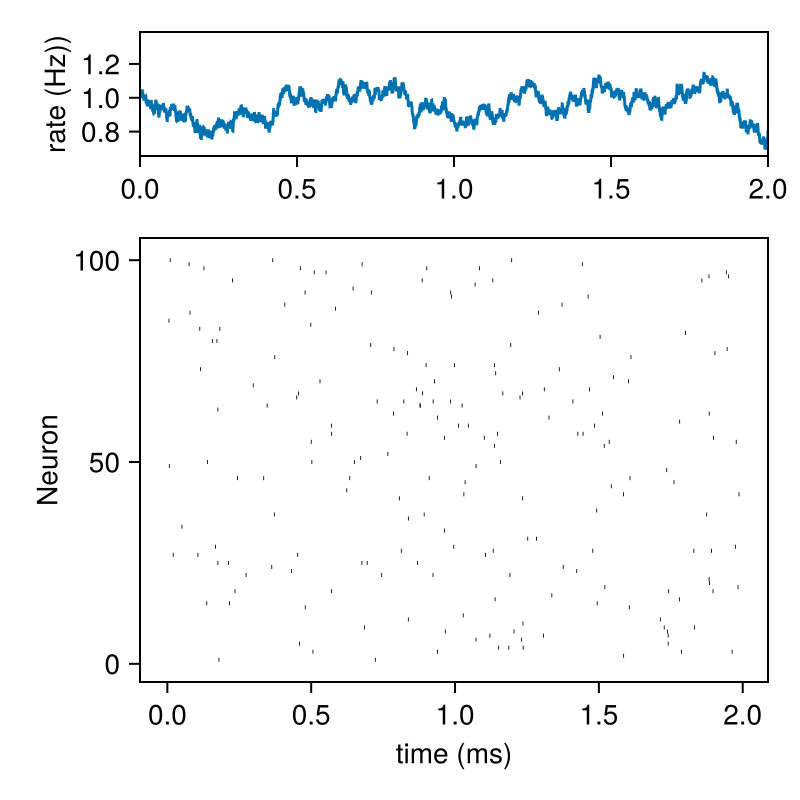

In [39]:
# spike rater plot
fig = Figure(size = (400, 400), sharex = true)
# the underlying signal on top
t_0 = 5
t_end = 7
# set x range
ax1 = Axis(fig[1, 1]; ylabel = "rate (Hz))", xgridvisible = false, ygridvisible = false)
xlims!(ax1, (0, t_end-t_0))
lines!(ax1, t .- t_0, rate)
# the spikes
ax2 = Axis(fig[2:4, 1]; xlabel = "time (ms)", ylabel = "Neuron", xgridvisible = false, ygridvisible = false)
dt = 0.001
ap_dur = 0.003 # s (duration of action potential about 1ms)
for i in 1:N
    for t_ in spikes[i]
        if t_0  < t_ < t_end
            ts = t_:dt:t_+ap_dur
            band!(ts .- t_0, ones(length(ts))*(i-0.5), ones(length(ts))*(i+0.5), color = :black)
        end
    end
end
# save as pdf
save("../figures/spike_rate_model.pdf", fig)
fig

In [8]:

# calculate entropy from the power spectrum of spike counts
bin = 0.1 # s
bins = 0:bin:t[end]
# last bin is always empty because no spike can happen after t[end]
spike_bins = collect(bins)[1:end-1]
spike_count = zeros(Int, length(bins)-1)
# sort spikes into bins
for i in 1:length(spikes)
    for t_ in spikes[i]
        bin_idx = findfirst(x -> x > t_, bins) - 1
        spike_count[bin_idx] += 1
    end
end

Pxx = periodogram(spike_count, fs=1/bin)
p = Pxx.power/ sum(Pxx.power)

# calculate entropy
H = -sum(p .* log2.(p))
print("Shannon entropy: $H\n")
fig = Figure()
ax = Axis(fig[1, 1]; xlabel = "Frequency (Hz)", ylabel = "Power", yscale=log10)
lines!(ax, Pxx.freq, Pxx.power, color = :black)
fig


Shannon entropy: NaN


Shannon Entropy (measured): 0


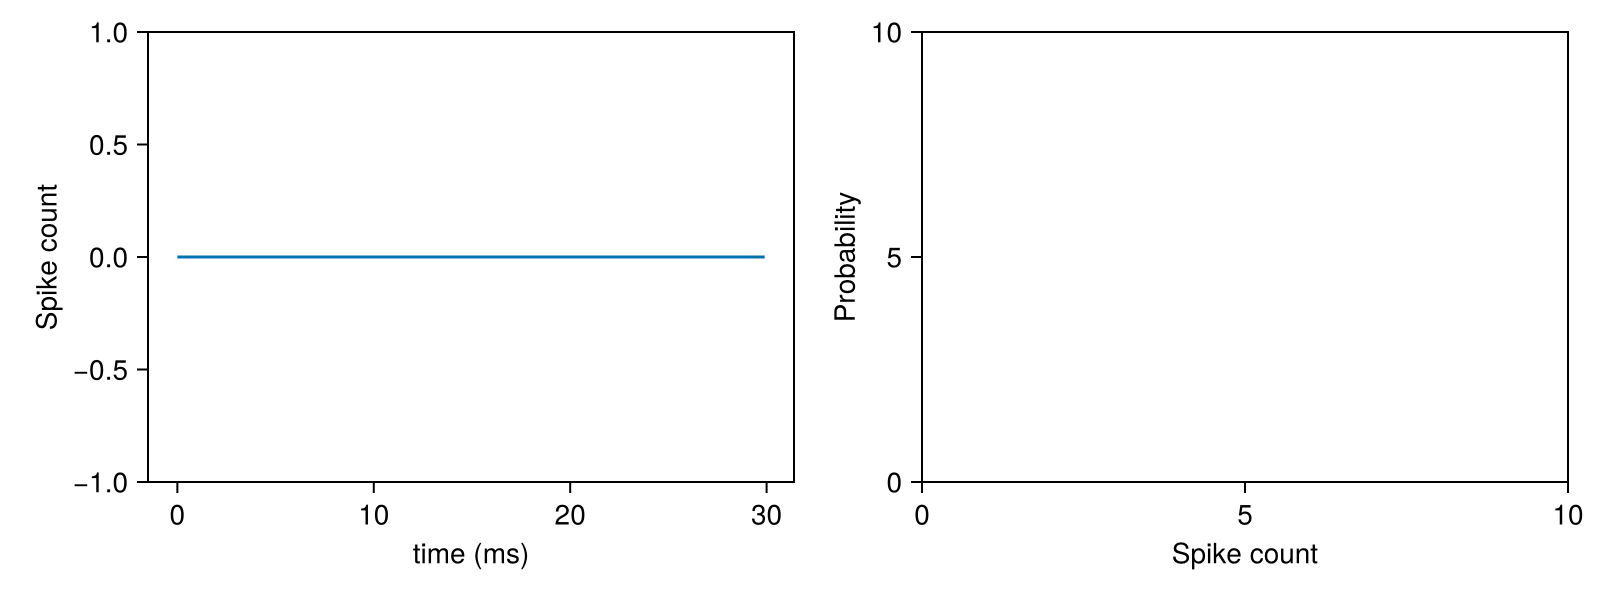

In [9]:
# calculate the entropy of the signal (makes no sense from the counting of spikes)
bin = 0.1 # s
bins = 0:bin:t[end]
# last bin is always empty because no spike can happen after t[end]
spike_bins = collect(bins)[1:end-1]
spike_count = zeros(Int, length(bins)-1)
# sort spikes into bins
for i in 1:length(spikes)
    for t_ in spikes[i]
        bin_idx = findfirst(x -> x > t_, bins) - 1
        spike_count[bin_idx] += 1
    end
end
# calculate the entropy from the probabiluty distribution of spike counts
# make histogram of spike counts
dist_count = normalize(fit(Histogram, spike_count, 0:1:maximum(spike_count)), mode = :probability)
H = 0
for i in 1:length(dist_count.weights)
    p = dist_count.weights[i]
    if p > 0
        H += -p * log(p)
    end
end
print("Shannon Entropy (measured): ", H, "\n")

fig = Figure(size = (800, 300))
# plot the spike count over time
ax = Axis(fig[1, 1]; xlabel = "time (ms)", ylabel = "Spike count", xgridvisible = false, ygridvisible = false)
lines!(ax, spike_bins, spike_count)
# plot the histogram
ax = Axis(fig[1, 2]; xlabel = "Spike count", ylabel = "Probability", xgridvisible = false, ygridvisible = false)
lines!(ax, dist_count.edges[1][1:end-1], dist_count.weights)
fig
